# 在不同的数据集上实现GAN 
- 二维Gaussian Mixture  
- moons dataset  
- MNSIT

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm
%matplotlib inline

## 定义画图函数

In [2]:
# 这是一个可视化数据的函数
def plot_data(X, labels, color = 'bone',title=None,savefig=None):
    fig, ax = plt.subplots(1, 1)
    markercolors = ['black' if label==1 else 'red' for label in labels]
    plt.scatter(X[:, 0], X[:, 1], s=8, c=markercolors, cmap=color)
    
    # 设置x-axis和y-axis的范围
    plt.xlim(-3,3)
    plt.ylim(-1,9)
    
    if title: plt.title(title)
    if savefig: plt.savefig(f".\gan_images\{title}.png")

## 数据集

D:\anaconda3\envs\dlpt\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


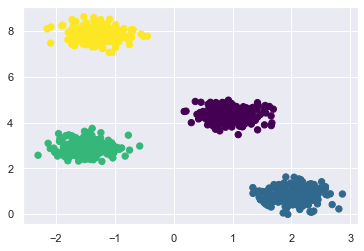

In [3]:
# GMM
from sklearn.datasets import samples_generator
from sklearn.cluster import KMeans
blobs, labels = samples_generator.make_blobs(n_samples=800, centers=4, cluster_std=0.30, random_state=0)
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=40, cmap='viridis')

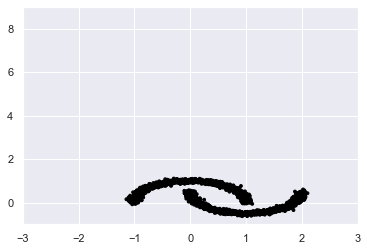

In [4]:
# moons
from sklearn.datasets import make_moons
moons, _ = make_moons(n_samples=256*10, noise=0.05)
labels = np.ones(moons.shape[0])
plot_data(moons, labels)

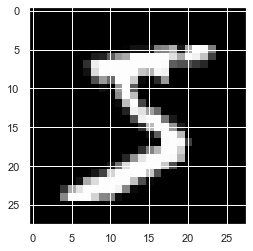

In [5]:
# MNIST
from torchvision import datasets, transforms
data = datasets.MNIST(root = './data/MNIST', train = True, download = True, transform = transforms.ToTensor())
mnist = data.data
plt.imshow(mnist[0],'gray')

## GAN 模型

In [6]:
image_size= 784
z_dim = 64
hidden_size = 256
# 定义生成器
model_G = nn.Sequential(
        nn.Linear(z_dim, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

# 定义判别器
model_D = nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

In [7]:
# 定义网络的优化器
batch_size, lr = 100, 1e-4
optimizer_G = optim.Adam(model_G.parameters(), lr = lr)
optimizer_D = optim.Adam(model_D.parameters(), lr = lr)

In [8]:
#训练
nb_epochs = 200
X = mnist.reshape(60000,-1).numpy()
for epoch in tqdm(range(nb_epochs)):
    np.random.shuffle(X)
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    for i, real_batch in enumerate(real_samples.split(batch_size)):
        #-------------------------------------------------
        #             优化判别器
        #-------------------------------------------------
        z = real_batch.new(real_batch.size(0), z_dim).normal_()
        fake_batch = model_G(z)
        D_scores_on_real = model_D(real_batch)
        D_scores_on_fake = model_D(fake_batch) 
        loss = - D_scores_on_real.log().mean()+ D_scores_on_fake.log().mean() 
        optimizer_D.zero_grad()  
        loss.backward()
        optimizer_D.step()
        
        #-------------------------------------------------
        #             优化生成器
        #-------------------------------------------------          
        z = real_batch.new(real_batch.size(0), z_dim).normal_()
        fake_batch = model_G(z)
        D_scores_on_fake = model_D(fake_batch)
        loss = - D_scores_on_fake.log().mean()
        optimizer_G.zero_grad()  # 
        loss.backward()
        optimizer_G.step()
        
    
        if epoch%2==0:
            if  i%200==0:
                with torch.no_grad():
                    fake_test = fake_batch[:8]
# for MNIST
                    outs = torch.cat([real_batch[:8].reshape(-1,1,28,28),fake_test.reshape(-1,1,28,28)],axis=0)
                    save_image(outs,os.path.join('gan_images', f'epoch-{epoch}-iter-{i}.png'),nrow = 8)
# for 其它数据
#                     fake_test_data = fake_test.detach().numpy()
#                     all_data = np.concatenate((X,fake_test_data),axis=0)
#                     all_labels = np.concatenate((np.ones(X.shape[0]),np.zeros(fake_test_data.shape[0])))
#                     plot_data(all_data, all_labels,title=f'epoch-{epoch}-iter-{i}',savefig=True)


 16%|█▌        | 31/200 [03:00<16:25,  5.83s/it]


KeyboardInterrupt: 

In [ ]:
outs.shape

## 制作动画

In [9]:
# 使用png图片制作动画
from glob import glob
files = glob('.\gan_mnist\*.png')

import imageio

gif_images = []
for file in files:
    gif_images.append(imageio.imread(file))   # 读取图片
imageio.mimsave("mnist.gif", gif_images, fps=1)   # 转化为gif动画

## 加分作业  
生成一维混合高斯分布数据 $p(x)=w_1 N(\mu_1,\sigma_1^2)+w_2 N(\mu_2,\sigma_2^2)$


### GMM for moons dataset

```python
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=4, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=4, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.3 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

from sklearn import mixture
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, moons)  


gmm10 = mixture.GaussianMixture(n_components=10, covariance_type='full', random_state=0)
plot_gmm(gmm10, moons, label=False)

moons_gmm_samples = gmm2.sample(800)[0]
all_data = np.concatenate((moons,moons_gmm_samples),axis=0)
all_labels = np.concatenate((np.ones(moons.shape[0]),np.zeros(moons_gmm_samples.shape[0])))
plot_data(all_data, all_labels)

moons_gmm_samples = gmm10.sample(800)[0]
all_data = np.concatenate((moons,moons_gmm_samples),axis=0)
all_labels = np.concatenate((np.ones(moons.shape[0]),np.zeros(moons_gmm_samples.shape[0])))
plot_data(all_data, all_labels)  

```